# Example of differences between 1 month and 12 month rolling data on measure shape

We had an email from a user:
>Dear team
>
>Would you be able to examine the following data;
>
>We observed a mismatch of data in [users] ICB.
>According to your website: Prescribing on Antibiotic stewardship: co-amoxiclav, cephalosporins & quinolones (KTT9)
>An increasing trend on broad spectrum abx was observed; with a latest value of 10.19% in Jul 2023.
>While other information sources indicates a decline trend; AMS Visual Analytics to support NHS antimicrobial stewardship improvement 2023/234 | PrescQIPP C.I.C
>ePACT2: Oracle Analytics Interactive Dashboards - Antimicrobial Stewardship (nhsbsa.nhs.uk)
>Thank you and much appreciated for looking into this.

We're currently writing a blog to explain these differences, and need to create some visual examples.

In [25]:
#import neccesary libraries
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import datetime

In [2]:
#pull data from BigQuery for antibiotic stewardship: co-amoxiclav, cephalosporins & quinolones (KTT9) measure
sql = """
SELECT
  month,
  pct_id,
  calc_value, 
  IEEE_DIVIDE(SUM(numerator) OVER(PARTITION BY pct_id ORDER BY month ROWS BETWEEN 11 PRECEDING AND CURRENT ROW),SUM(denominator) OVER(PARTITION BY pct_id ORDER BY month ROWS BETWEEN 11 PRECEDING AND CURRENT ROW)) as rolling_calc_value # calculate rolling 12 month for the measure
FROM
  measures.ccg_data_ktt9_cephalosporins
ORDER BY
  pct_id, month
  """
exportfile = os.path.join("..","data","df.csv")
df = bq.cached_read(sql, csv_path=exportfile, use_cache=False)

Downloading: 100%|██████████| 6466/6466 [00:00<00:00, 11406.74rows/s]


In [3]:
#filter out anything before Oct 2019, so there is always 12 months data in the rolling figure
df = df[df['month'] >= '2019-10-01']

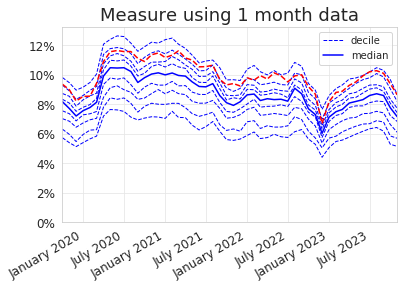

In [26]:
#define y axis percentage formatter
def percentage_formatter(x, pos):
    return f'{x:.0%}'
#create decile chart for 1 month data using user ICB as example
charts.deciles_chart(
        df,
        period_column='month',
        column='calc_value',
        title="Measure using 1 month data",
        show_outer_percentiles=False)

#add in user ICB
df_subject = df.loc[df['pct_id'] == '92G']
plt.plot(df_subject['month'], df_subject['calc_value'], 'r--')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
plt.savefig(os.path.join("..","1_month.png"),dpi=300, bbox_inches='tight') #save plot in root directory as png

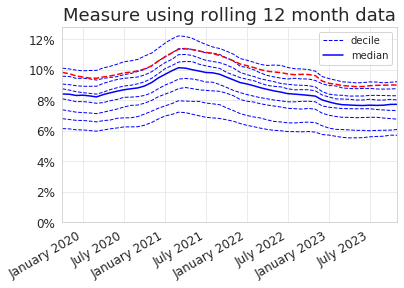

In [27]:
#create decile chart for 12 month rolling data using user ICB as example
charts.deciles_chart(
        df,
        period_column='month',
        column='rolling_calc_value',
        title="Measure using rolling 12 month data",
        show_outer_percentiles=False)

#add in user ICB
df_subject = df.loc[df['pct_id'] == '92G']
plt.plot(df_subject['month'], df_subject['rolling_calc_value'], 'r--')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
plt.savefig(os.path.join("..","12_month.png"),dpi=300, bbox_inches='tight') #save plot in root directory as png